# The final model
 

## Model v5.1

In [1]:
import warnings

from sklearn.metrics import root_mean_squared_error

warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
from data import load_data_selected_features

train_data, additional_train_data, test_data = load_data_selected_features()

In [3]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 150996 entries, p01_0 to p12_25298
Columns: 507 entries, p_num to bg+1:00
dtypes: float64(433), object(74)
memory usage: 585.2+ MB


In [4]:
additional_train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 168588 entries, p01_test_12 to p24_test_94938
Columns: 507 entries, p_num to bg+1:00
dtypes: float64(433), object(74)
memory usage: 657.4+ MB


In [5]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3644 entries, p01_8459 to p24_260
Columns: 506 entries, p_num to activity-0:00
dtypes: float64(432), object(74)
memory usage: 14.2+ MB


# Prepare the data

In [6]:
from pipelines_selected_features import pipeline

all_train_data = pd.concat([train_data, additional_train_data], axis=0)
all_train_data_transformed = pipeline.fit_transform(all_train_data)

train_data_transformed = all_train_data_transformed[:len(train_data)]
additional_train_data_transformed = all_train_data_transformed[len(train_data):]

X_train = train_data_transformed.drop(columns=['bg+1:00'])
y_train = train_data_transformed['bg+1:00']

X_additional_train = additional_train_data_transformed.drop(columns=['bg+1:00'])
y_additional_train = additional_train_data_transformed['bg+1:00']

## Predict for validation data and check results

In [7]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input, Activation
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from scikeras.wrappers import KerasRegressor
from tensorflow.keras import regularizers


def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))


def create_dnn_model(input_dimension: int):
    dnn = Sequential([
        Input(shape=(input_dimension,)),
        Dense(128, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
        Dropout(0.3),
        Dense(64, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
        Dropout(0.3),
        Dense(32, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
        Dropout(0.3),
        Dense(1, activation='linear')
    ])

    dnn.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='mse',
        metrics=[rmse]
    )

    return dnn


def model_with_pretrained_weights():
    dnn = create_dnn_model(X_train.shape[1])
    dnn.load_weights('v5.1.weights.h5')  # Load the pre-trained weights

    # Freeze all layers except the last one (optional)
    for layer in dnn.layers:
        layer.trainable = False
    # Unfreeze the output layer if you want to fine-tune it
    # dnn.layers[-1].trainable = True

    dnn.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='mse',
        metrics=[rmse]
    )
    return dnn


Epoch 1/100
8934/8934 - 5s - 544us/step - loss: 6.5720 - rmse: 2.4923 - val_loss: 4.7553 - val_rmse: 2.1446
Epoch 2/100
8934/8934 - 4s - 488us/step - loss: 4.8985 - rmse: 2.1728 - val_loss: 4.5626 - val_rmse: 2.0996
Epoch 3/100
8934/8934 - 4s - 501us/step - loss: 4.5267 - rmse: 2.0872 - val_loss: 4.4424 - val_rmse: 2.0693
Epoch 4/100
8934/8934 - 4s - 473us/step - loss: 4.3689 - rmse: 2.0494 - val_loss: 4.3848 - val_rmse: 2.0536
Epoch 5/100
8934/8934 - 4s - 472us/step - loss: 4.3105 - rmse: 2.0345 - val_loss: 4.5078 - val_rmse: 2.0827
Epoch 6/100
8934/8934 - 4s - 471us/step - loss: 4.2888 - rmse: 2.0276 - val_loss: 4.3647 - val_rmse: 2.0482
Epoch 7/100
8934/8934 - 4s - 472us/step - loss: 4.2697 - rmse: 2.0223 - val_loss: 4.4364 - val_rmse: 2.0628
Epoch 8/100
8934/8934 - 4s - 470us/step - loss: 4.2572 - rmse: 2.0179 - val_loss: 4.3101 - val_rmse: 2.0316
Epoch 9/100
8934/8934 - 4s - 494us/step - loss: 4.2534 - rmse: 2.0164 - val_loss: 4.2896 - val_rmse: 2.0256
Epoch 10/100
8934/8934 - 4s 

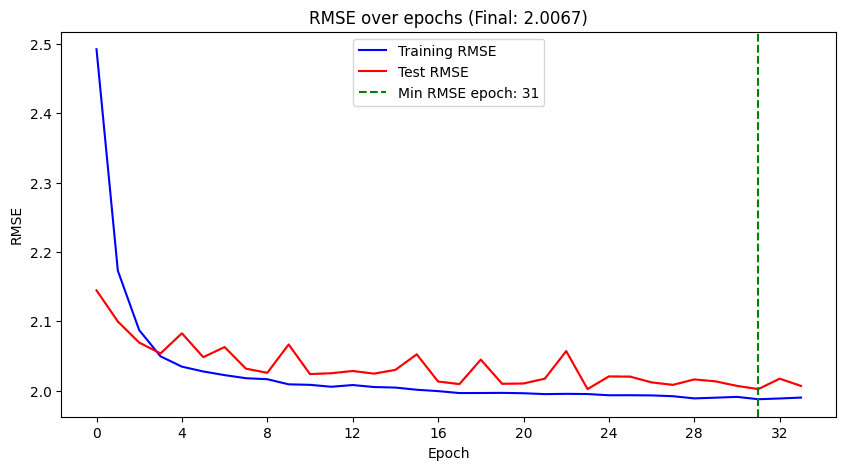

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import StackingRegressor, HistGradientBoostingRegressor
from sklearn.linear_model import LassoLarsIC, Ridge
from tensorflow.keras.callbacks import EarlyStopping
from model_performance_calculations import get_history_line_chart

hgb_estimator = HistGradientBoostingRegressor(
    max_depth=4,
    learning_rate=0.05,
    max_iter=500,
    min_samples_leaf=20,
    early_stopping='auto',
    validation_fraction=0.1,
    n_iter_no_change=10,
    verbose=0
)

lasso_lars_ic_base_model = LassoLarsIC(
    criterion='aic',
    eps=0.03922948513965659,
    max_iter=1944,
    noise_variance=5.4116687755186035e-05,
    positive=False,
)

knn_base_estimator = KNeighborsRegressor(
    leaf_size=30,
    metric='minkowski',
    n_neighbors=7,
    p=2,
    weights='distance'
)

xgb_base_estimator = XGBRegressor(
    n_estimators=1000,
    max_depth=5,
    learning_rate=0.01,
    colsample_bytree=0.8,
    subsample=0.8,
    objective='reg:squarederror',
    random_state=42,
)

X_additional_train, X_additional_val, y_additional_train, y_additional_val = train_test_split(
    X_additional_train, y_additional_train, random_state=42, test_size=0.2, shuffle=True)

# pretrain the DNN and use the weights in the stacking model
pretrained_dnn = create_dnn_model(X_train.shape[1])
pretrained_dnn.fit(
    pd.concat([X_train, X_additional_train], axis=0),
    pd.concat([y_train, y_additional_train], axis=0),
    epochs=100,
    verbose=2,
    validation_data=(X_additional_val, y_additional_val),
    validation_split=0.2,
    batch_size=32,
    callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)]
)

history = pretrained_dnn.history.history
epochs = len(history['loss'])

print('Pretrain with Validation Data')
pretrained_dnn.fit(
    X_additional_val,
    y_additional_val,
    batch_size=32,
    verbose=2,
    epochs=epochs
)

pretrained_dnn.save_weights('v5.1.weights.h5')

keras_regressor = KerasRegressor(
    model=model_with_pretrained_weights,
    epochs=1,
    verbose=2
)

estimators = [
    ('hgb', hgb_estimator),
    ('lasso_lars_ic', lasso_lars_ic_base_model),
    ('knn', knn_base_estimator),
    ('xgb', xgb_base_estimator),
    ('dnn', keras_regressor)
]

model = StackingRegressor(estimators=estimators, final_estimator=Ridge(alpha=0.1), n_jobs=1, verbose=2)

get_history_line_chart([history]).show()

07:14:03 - Start training
07:14:03 - Calculate performance for hgb
07:14:03 - Selected splitter: ShuffleSplit(n_splits=5, random_state=42, test_size=0.2, train_size=None)
07:14:03 - Split 1 - Model: hgb
07:14:03 - Fitting the model
07:14:15 - Predicting
07:14:15 - Calculating scores
07:14:15 - R^2: 0.5967215149153622, RMSE: 2.0680820028927047, MAE: 1.5450391804908004, MSE: 4.276963170688701
07:14:15 - Split 2 - Model: hgb
07:14:16 - Fitting the model
07:14:27 - Predicting
07:14:27 - Calculating scores
07:14:27 - R^2: 0.6020236413203468, RMSE: 2.0570105676893466, MAE: 1.5362978604783533, MSE: 4.231292475585649
07:14:27 - Split 3 - Model: hgb
07:14:27 - Fitting the model
07:14:38 - Predicting
07:14:38 - Calculating scores
07:14:38 - R^2: 0.5951299872249676, RMSE: 2.067946929991136, MAE: 1.5473232536644361, MSE: 4.276404505259764
07:14:38 - Split 4 - Model: hgb
07:14:38 - Fitting the model
07:14:50 - Predicting
07:14:51 - Calculating scores
07:14:51 - R^2: 0.6007984354752175, RMSE: 2.0530

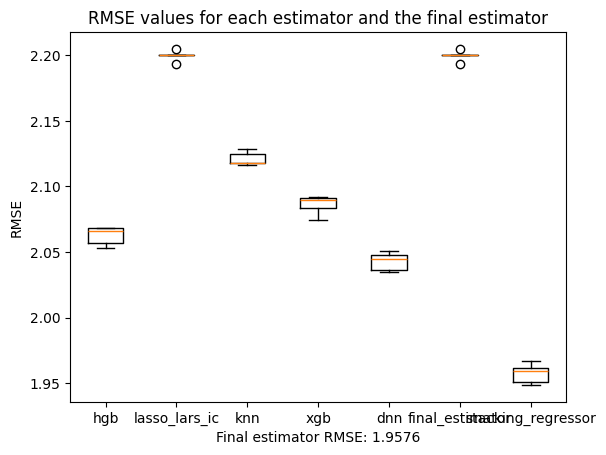

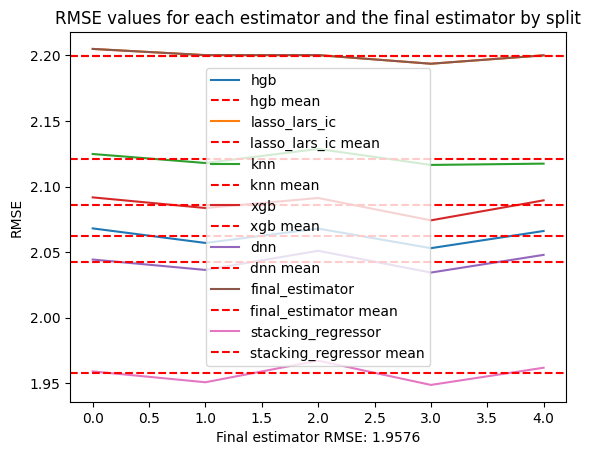

In [9]:
from datetime import datetime
import os
from model_performance_calculations import calculate_stacking_regressor_performance, get_rmse_boxplot_chart, get_rmse_line_chart, save_performances, save_model

date_time = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
model_name = f'{date_time}-model-v5.1-all-tuned-base'

save_model(model, os.path.join('models', f'{model_name}.pkl'))

performances = calculate_stacking_regressor_performance(model, X_train, y_train, X_additional_train, y_additional_train, n_splits=5)
save_performances(performances, os.path.join('models', f'{model_name}-performances.json'))

get_rmse_boxplot_chart(performances).show()
get_rmse_line_chart(performances).show()

In [10]:
import numpy as np
from pipelines_selected_features import pipeline

all_train_data_transformed = pipeline.fit_transform(pd.concat([train_data, additional_train_data], axis=0))

X_train = all_train_data_transformed.drop(columns=['bg+1:00'])
y_train = all_train_data_transformed['bg+1:00']

model.fit(X_train, y_train)

X_test = pipeline.transform(test_data)
y_pred = model.predict(X_test)

if np.sum(y_pred < 0) > 0:
    print(f'Number of negative values: {np.sum(y_pred < 0)}')
    bg_min_train = np.min(y_train)
    print(f'Min value: {np.min(y_pred)}')
    print(f'Filling negative values with {bg_min_train}')
    y_pred = np.where(y_pred < 0, bg_min_train, y_pred)

test_data['bg+1:00'] = y_pred
test_data.head()

9987/9987 - 3s - 269us/step - loss: 4.3138 - rmse: 3.8426
7990/7990 - 2s - 302us/step - loss: 4.1874 - rmse: 3.8863
1998/1998 - 1s - 272us/step
7990/7990 - 2s - 306us/step - loss: 4.4176 - rmse: 3.8828
1998/1998 - 1s - 269us/step
7990/7990 - 2s - 300us/step - loss: 4.2869 - rmse: 3.8350
1998/1998 - 1s - 271us/step
7990/7990 - 2s - 301us/step - loss: 4.5319 - rmse: 3.8301
1998/1998 - 1s - 270us/step
7990/7990 - 2s - 301us/step - loss: 4.2548 - rmse: 3.7668
1998/1998 - 1s - 269us/step
114/114 - 0s - 648us/step


,p_num,time,bg-5:55,bg-5:50,bg-5:45,bg-5:40,bg-5:35,bg-5:30,bg-5:25,bg-5:20,...,activity-0:40,activity-0:35,activity-0:30,activity-0:25,activity-0:20,activity-0:15,activity-0:10,activity-0:05,activity-0:00,bg+1:00
id,,,,,,,,,,,,,,,,,,,,,
p01_8459,p01,06:45:00,NaN,9.2,NaN,NaN,10.2,NaN,NaN,10.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.105317
p01_8460,p01,11:25:00,NaN,NaN,9.9,NaN,NaN,9.4,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Walk,Walk,Walk,5.967337
p01_8461,p01,14:45:00,NaN,5.5,NaN,NaN,5.5,NaN,NaN,5.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.385392
p01_8462,p01,04:30:00,NaN,3.4,NaN,NaN,3.9,NaN,NaN,4.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.070639
p01_8463,p01,04:20:00,NaN,NaN,8.3,NaN,NaN,10.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.732199


In [11]:
submission = pd.DataFrame(test_data['bg+1:00'])
submission

,bg+1:00
id,
p01_8459,8.105317
p01_8460,5.967337
p01_8461,7.385392
p01_8462,11.070639
p01_8463,6.732199
...,...
p24_256,6.343858
p24_257,10.890640
p24_258,6.369135


In [12]:
submission.to_csv(f'submission-{os.path.basename(os.getcwd())}.csv')

In [13]:
y_pred = model.predict(X_train)

root_mean_squared_error(y_train, y_pred)


9987/9987 - 3s - 279us/step


NameError: name 'root_mean_squared_error' is not defined

In [14]:
from sklearn.metrics import root_mean_squared_error
root_mean_squared_error(y_train, y_pred)

np.float64(1.8887912799716822)